In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import re
from scipy.ndimage import uniform_filter1d


# Task 1

In [2]:
# Function to generate random means
def generate_means(N, mean_load, var_load, mean_latency, var_latency):
    print('Mean Load:', mean_load)
    print('Variance Load:', var_load)
    print('Mean Latency:', mean_latency)
    print('Variance Latency:', var_latency)
    means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)
    means_latency = np.random.normal(loc=mean_latency, scale=np.sqrt(var_latency), size=N)

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plotting means_load
    ax1.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
    ax1.set_title('Random Means for Load')
    ax1.set_xlabel('Node')
    ax1.set_ylabel('Mean Load')
    ax1.legend()
    ax1.grid(True)

    # Plotting means_latency
    ax2.plot(means_latency, marker='o', linestyle='-', color='r', label='means_latency')
    ax2.set_title('Random Means for Latency')
    ax2.set_xlabel('Node')
    ax2.set_ylabel('Mean Latency')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return means_load, means_latency

In [3]:
# Function to generate AR(1) data
def generate_ar1_data(N, T, means_load, means_latency, theta):
    print('Theta:', theta)
    load = np.zeros((N, T))
    ar1_latency = np.zeros((N, T))
    ar1_standardized_latency = np.zeros((N, T))
    uniform_latency = np.zeros((N, T))
    latency = np.zeros((N, T))

    def generate_ar1(theta, n, mean_node):
        ar1 = np.zeros(n)
        ar1[0] = mean_node
        for t in range(1, n):
            ar1[t] = ar1[t - 1] + (1 - theta) * (mean_node - ar1[t - 1]) + np.random.normal(0, 1)
        return ar1

    for i in range(N):
        load[i] = generate_ar1(theta, T, means_load[i])
        ar1_latency[i] = generate_ar1(theta, T, means_latency[i])
        ar1_standardized_latency[i] = (ar1_latency[i] - np.mean(ar1_latency[i])) / np.std(ar1_latency[i])
        uniform_latency[i] = norm.cdf(ar1_standardized_latency[i])
        lambda_param = 1
        latency[i] = -np.log(1 - uniform_latency[i]) / lambda_param
    
    return load, latency

In [4]:
# Function to generate IID data
def generate_iid_data(N, T, means_load, means_latency):
    rates_latency = means_latency

    load = np.zeros((N, T))
    latency = np.zeros((N, T))

    for i in range(N):
        load[i] = np.random.normal(loc=means_load[i], scale=1, size=T)
        latency[i] = np.random.exponential(scale=1.0/rates_latency[i], size=T)

    return load, latency

In [5]:
def epsilon_greedy_algorithm(load, latency, epsilons, alpha=1.0):
    def epsilon_greedy(epsilon, rewards, estimated_means):
        if np.random.rand() < epsilon:
            return np.random.randint(len(rewards))
        else:
            return np.argmax(estimated_means)

    def calculate_regret(true_means, chosen_means):
        mu_star = np.max(true_means)
        regret = mu_star - chosen_means
        return regret

    results = {}
    for epsilon in epsilons:
        rewards_load = 1 / (1 + load)
        rewards_latency = np.exp(-alpha * latency)

        estimated_means_load = np.zeros(N)
        estimated_means_latency = np.zeros(N)
        chosen_counts_load = np.zeros(N)
        chosen_counts_latency = np.zeros(N)

        cumulative_regret_load = np.zeros(T)
        cumulative_regret_latency = np.zeros(T)
        single_step_regret_load = np.zeros(T)
        single_step_regret_latency = np.zeros(T)

        for t in range(T):
            chosen_node_load = epsilon_greedy(epsilon, rewards_load[:, t], estimated_means_load)
            chosen_node_latency = epsilon_greedy(epsilon, rewards_latency[:, t], estimated_means_latency)

            reward_load = rewards_load[chosen_node_load, t]
            reward_latency = rewards_latency[chosen_node_latency, t]

            chosen_counts_load[chosen_node_load] += 1
            chosen_counts_latency[chosen_node_latency] += 1

            estimated_means_load[chosen_node_load] += (reward_load - estimated_means_load[chosen_node_load]) / chosen_counts_load[chosen_node_load]
            estimated_means_latency[chosen_node_latency] += (reward_latency - estimated_means_latency[chosen_node_latency]) / chosen_counts_latency[chosen_node_latency]

            single_step_regret_load[t] = calculate_regret(np.mean(rewards_load, axis=1), estimated_means_load[chosen_node_load])
            single_step_regret_latency[t] = calculate_regret(np.mean(rewards_latency, axis=1), estimated_means_latency[chosen_node_latency])

            if t == 0:
                cumulative_regret_load[t] = single_step_regret_load[t]
                cumulative_regret_latency[t] = single_step_regret_latency[t]
            else:
                cumulative_regret_load[t] = cumulative_regret_load[t - 1] + single_step_regret_load[t]
                cumulative_regret_latency[t] = cumulative_regret_latency[t - 1] + single_step_regret_latency[t]

        results[epsilon] = {
            'single_step_regret_load': single_step_regret_load,
            'cumulative_regret_load': cumulative_regret_load,
            'single_step_regret_latency': single_step_regret_latency,
            'cumulative_regret_latency': cumulative_regret_latency
        }

    return results

In [6]:
# def epsilon_greedy_algorithm(load, latency, epsilons, alpha=1.0):
#     def epsilon_greedy(epsilon, rewards, estimated_means):
#         if np.random.rand() < epsilon:
#             return np.random.randint(len(rewards))
#         else:
#             return np.argmax(estimated_means)
# 
#     def calculate_regret(observed_rewards, chosen_means):
#         mu_star = np.max(observed_rewards)
#         regret = mu_star - chosen_means
#         return regret
# 
#     results = {}
#     N, T = load.shape
#     for epsilon in epsilons:
#         rewards_load = 1 / (1 + load)
#         rewards_latency = np.exp(-alpha * latency)
# 
#         estimated_means_load = np.zeros(N)
#         estimated_means_latency = np.zeros(N)
#         chosen_counts_load = np.zeros(N)
#         chosen_counts_latency = np.zeros(N)
# 
#         cumulative_regret_load = np.zeros(T)
#         cumulative_regret_latency = np.zeros(T)
#         single_step_regret_load = np.zeros(T)
#         single_step_regret_latency = np.zeros(T)
# 
#         all_rewards_load = []
#         all_rewards_latency = []
# 
#         for t in range(T):
#             chosen_node_load = epsilon_greedy(epsilon, rewards_load[:, t], estimated_means_load)
#             chosen_node_latency = epsilon_greedy(epsilon, rewards_latency[:, t], estimated_means_latency)
# 
#             reward_load = rewards_load[chosen_node_load, t]
#             reward_latency = rewards_latency[chosen_node_latency, t]
# 
#             chosen_counts_load[chosen_node_load] += 1
#             chosen_counts_latency[chosen_node_latency] += 1
# 
#             estimated_means_load[chosen_node_load] += (reward_load - estimated_means_load[chosen_node_load]) / chosen_counts_load[chosen_node_load]
#             estimated_means_latency[chosen_node_latency] += (reward_latency - estimated_means_latency[chosen_node_latency]) / chosen_counts_latency[chosen_node_latency]
# 
#             all_rewards_load.append(reward_load)
#             all_rewards_latency.append(reward_latency)
# 
#             single_step_regret_load[t] = calculate_regret(all_rewards_load, estimated_means_load[chosen_node_load])
#             single_step_regret_latency[t] = calculate_regret(all_rewards_latency, estimated_means_latency[chosen_node_latency])
# 
#             if t == 0:
#                 cumulative_regret_load[t] = single_step_regret_load[t]
#                 cumulative_regret_latency[t] = single_step_regret_latency[t]
#             else:
#                 cumulative_regret_load[t] = cumulative_regret_load[t - 1] + single_step_regret_load[t]
#                 cumulative_regret_latency[t] = cumulative_regret_latency[t - 1] + single_step_regret_latency[t]
# 
#         results[epsilon] = {
#             'single_step_regret_load': single_step_regret_load,
#             'cumulative_regret_load': cumulative_regret_load,
#             'single_step_regret_latency': single_step_regret_latency,
#             'cumulative_regret_latency': cumulative_regret_latency
#         }
# 
#     return results

In [7]:
def plot_combined_results(load, latency, results, epsilons, tittle = 'Performance Metrics over Time', smoothing_window=50):
    fig, axs = plt.subplots(2, 3, figsize=(18, 9))

    # Adding overall title
    fig.suptitle(tittle, fontsize=16)

    # Plotting load data
    for i in range(load.shape[0]):
        axs[0, 0].plot(load[i], label=f'Node {i + 1}')
    axs[0, 0].set_title('Load over Time')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Load')
    axs[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plotting latency data
    for i in range(latency.shape[0]):
        axs[1, 0].plot(latency[i], label=f'Node {i + 1}')
    axs[1, 0].set_title('Latency over Time')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Latency')
    axs[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Single Step Regret for Load
    for epsilon in epsilons:
        smoothed_data = uniform_filter1d(results[epsilon]['single_step_regret_load'], size=smoothing_window)
        axs[0, 1].plot(smoothed_data, label=f'epsilon={epsilon}')
        # axs[0, 1].plot(results[epsilon]['single_step_regret_load'], label=f'epsilon={epsilon}')
    axs[0, 1].set_title('Single Step Regret for Load')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Regret')
    axs[0, 1].legend()

    # Single Step Regret for Latency
    for epsilon in epsilons:
        smoothed_data = uniform_filter1d(results[epsilon]['single_step_regret_latency'], size=smoothing_window)
        axs[1, 1].plot(smoothed_data, label=f'epsilon={epsilon}')
        # axs[1, 1].plot(results[epsilon]['single_step_regret_latency'], label=f'epsilon={epsilon}')
    axs[1, 1].set_title('Single Step Regret for Latency')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Regret')
    axs[1, 1].legend()

    # Cumulative Regret for Load
    for epsilon in epsilons:
        axs[0, 2].plot(results[epsilon]['cumulative_regret_load'], label=f'epsilon={epsilon}')
    axs[0, 2].set_title('Cumulative Regret for Load')
    axs[0, 2].set_xlabel('Time')
    axs[0, 2].set_ylabel('Cumulative Regret')
    axs[0, 2].legend()

    # Cumulative Regret for Latency
    for epsilon in epsilons:
        axs[1, 2].plot(results[epsilon]['cumulative_regret_latency'], label=f'epsilon={epsilon}')
    axs[1, 2].set_title('Cumulative Regret for Latency')
    axs[1, 2].set_xlabel('Time')
    axs[1, 2].set_ylabel('Cumulative Regret')
    axs[1, 2].legend()

    plt.tight_layout()

    # Create 'Results' directory if it doesn't exist
    if not os.path.exists('Results'):
        os.makedirs('Results')

    # Sanitize the title for use as a filename
    sanitized_title = sanitize_filename(tittle)

    # Save the figure to the 'Results' directory
    plt.savefig(f'Results/{sanitized_title}.png')

    plt.show()

In [8]:
def sanitize_filename(filename):
    # Remove or replace invalid characters
    return re.sub(r'[<>:"/\\|?*;]', '_', filename)

Mean Load: 15
Variance Load: 5
Mean Latency: 10
Variance Latency: 2


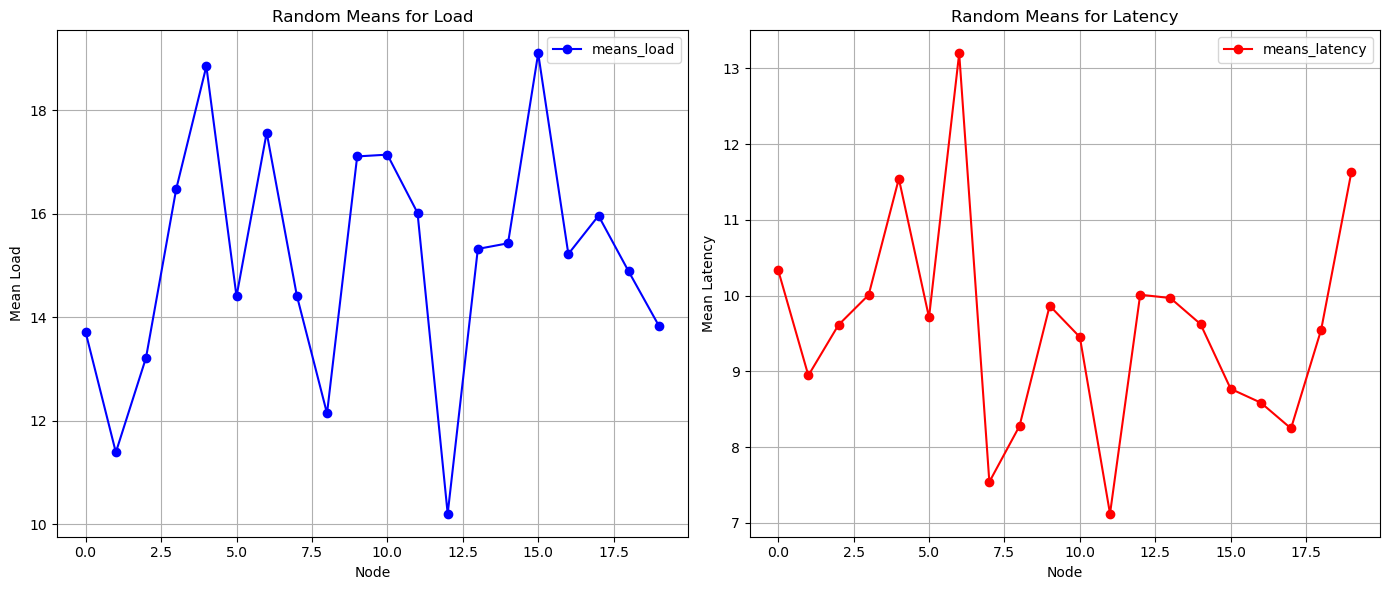

Theta: 0.5


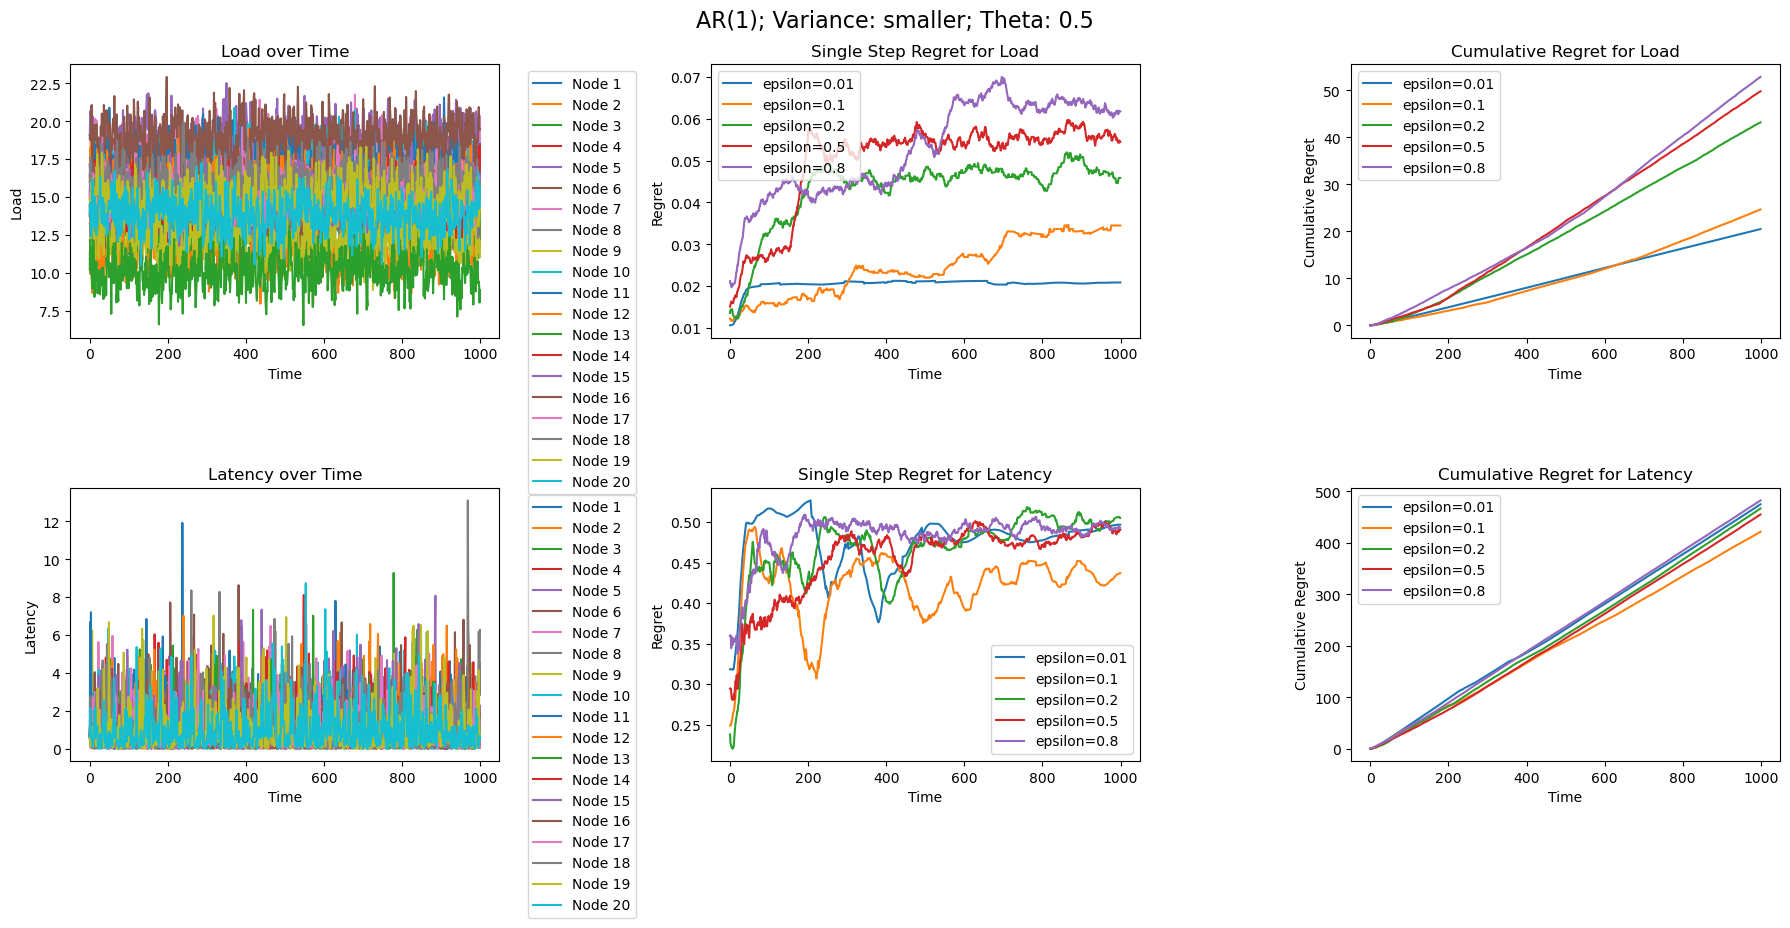

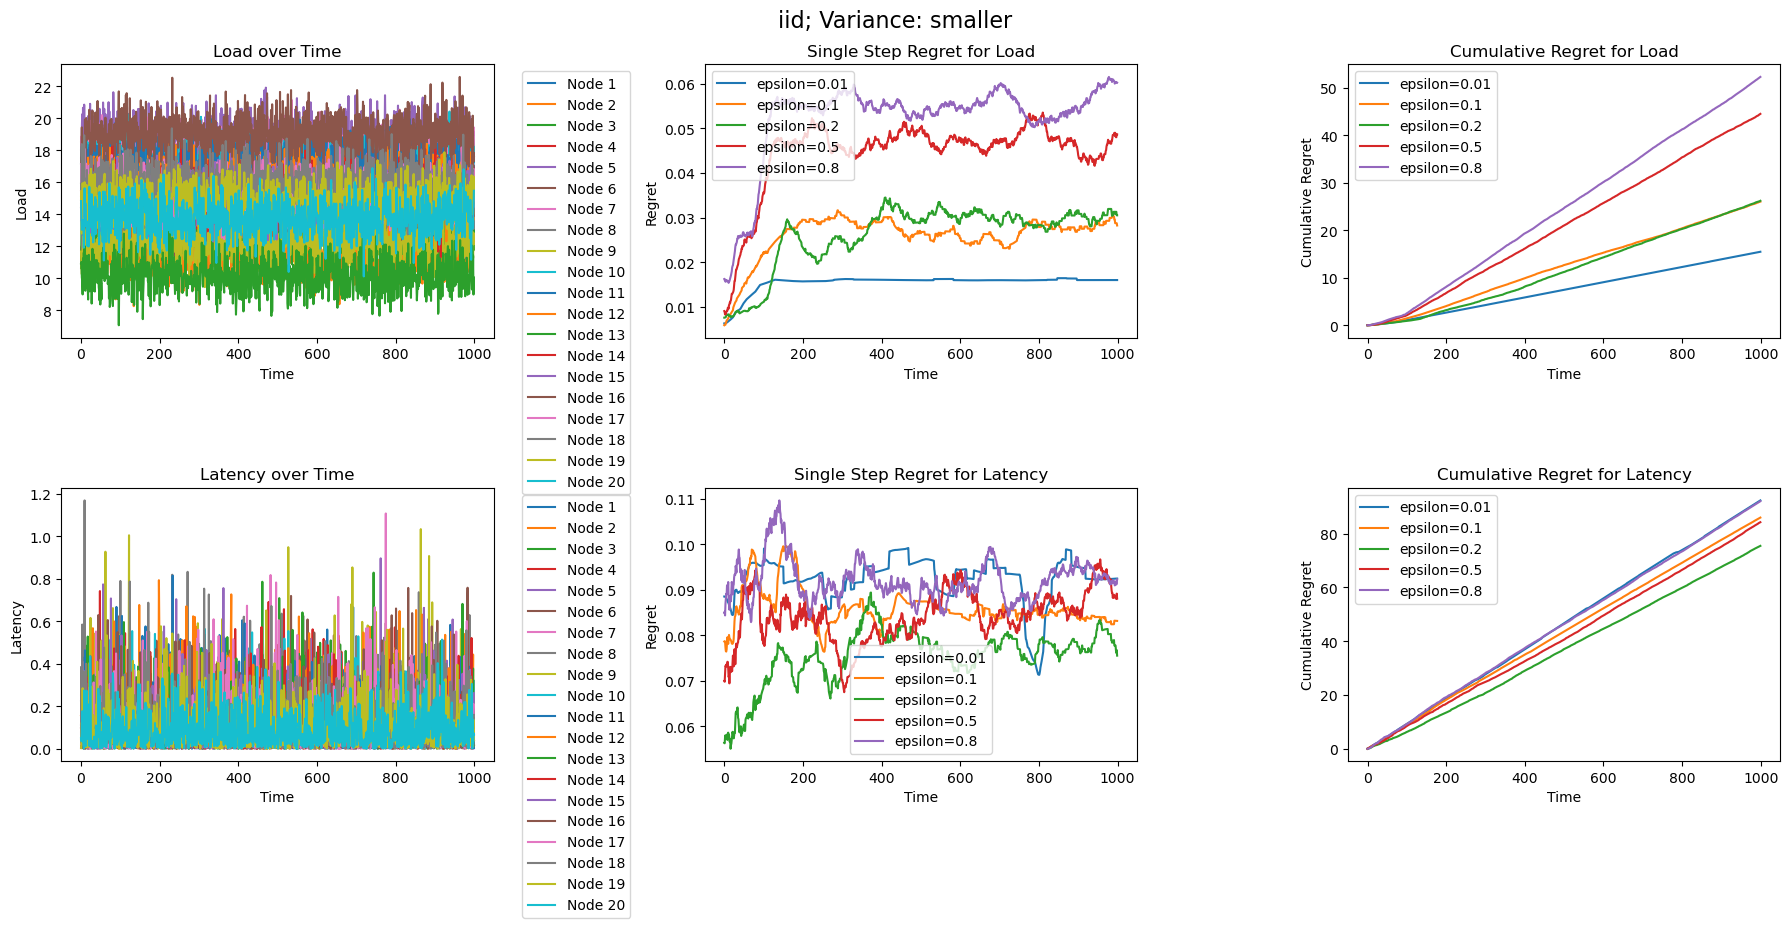

In [9]:
N = 20
T = 1000
mean_load = 15
var_load = 5
mean_latency = 10
var_latency = 2
theta = 0.5
epsilons = [0.01, 0.1, 0.2, 0.5, 0.8]

means_load, means_latency = generate_means(N, mean_load, var_load, mean_latency, var_latency)

load_ar1, latency_ar1 = generate_ar1_data(N, T, means_load, means_latency, theta)
results_ar1 = epsilon_greedy_algorithm(load_ar1, latency_ar1, epsilons)
plot_combined_results(load_ar1, latency_ar1, results_ar1, epsilons, 'AR(1); Variance: smaller; Theta: 0.5')

load_iid, latency_iid = generate_iid_data(N, T, means_load, means_latency)
results_iid = epsilon_greedy_algorithm(load_iid, latency_iid, epsilons)
plot_combined_results(load_iid, latency_iid, results_iid, epsilons, 'iid; Variance: smaller')

In [10]:
N = 20
T = 1000
mean_load = 15
var_load = 10
mean_latency = 10
var_latency = 5
theta = 0.5
epsilons = [0.01, 0.1, 0.2, 0.5, 0.8]

Mean Load: 15
Variance Load: 10
Mean Latency: 10
Variance Latency: 5


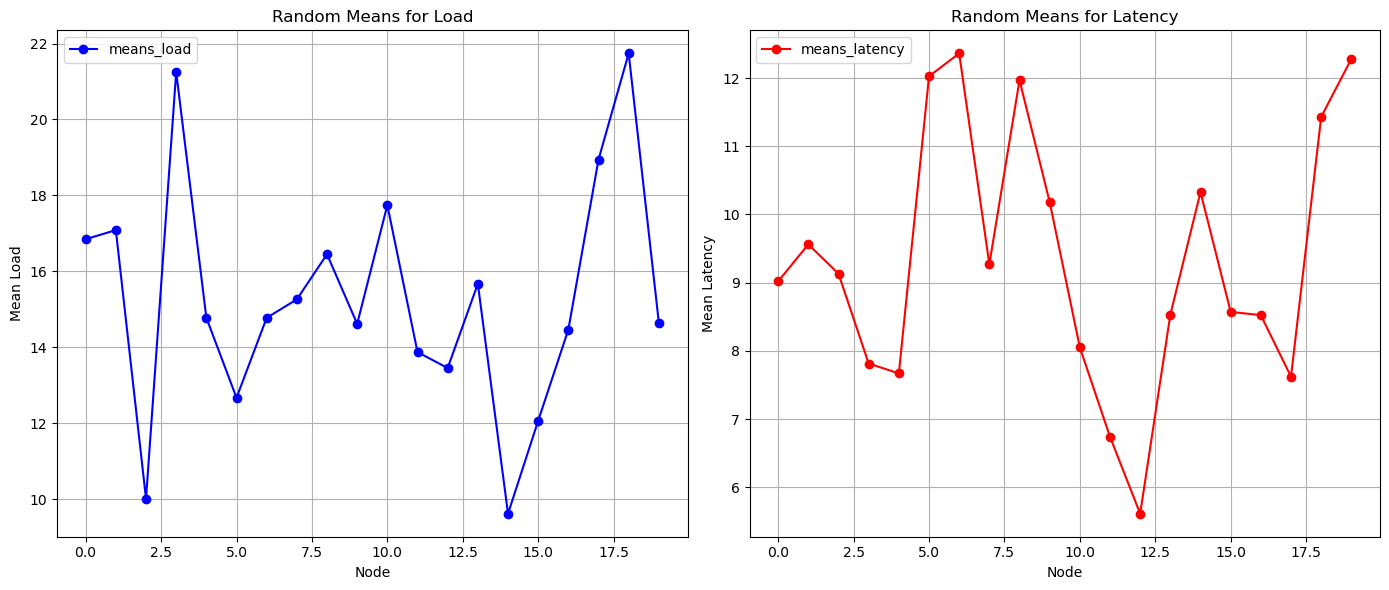

Theta: 0.5


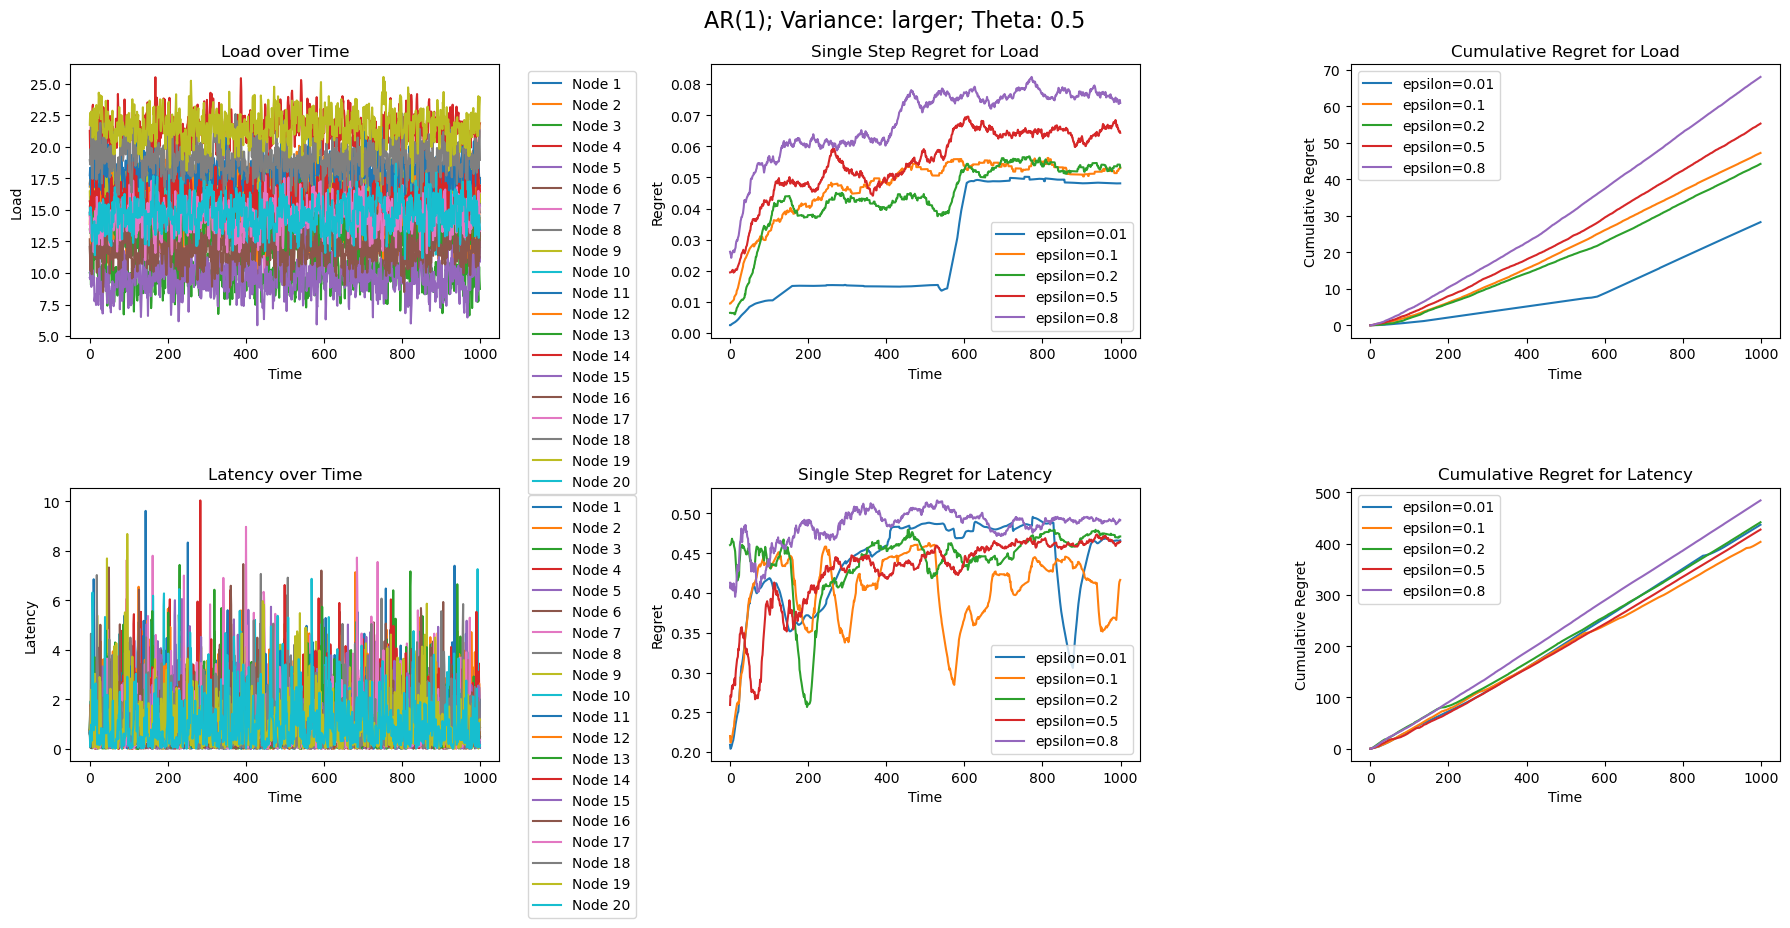

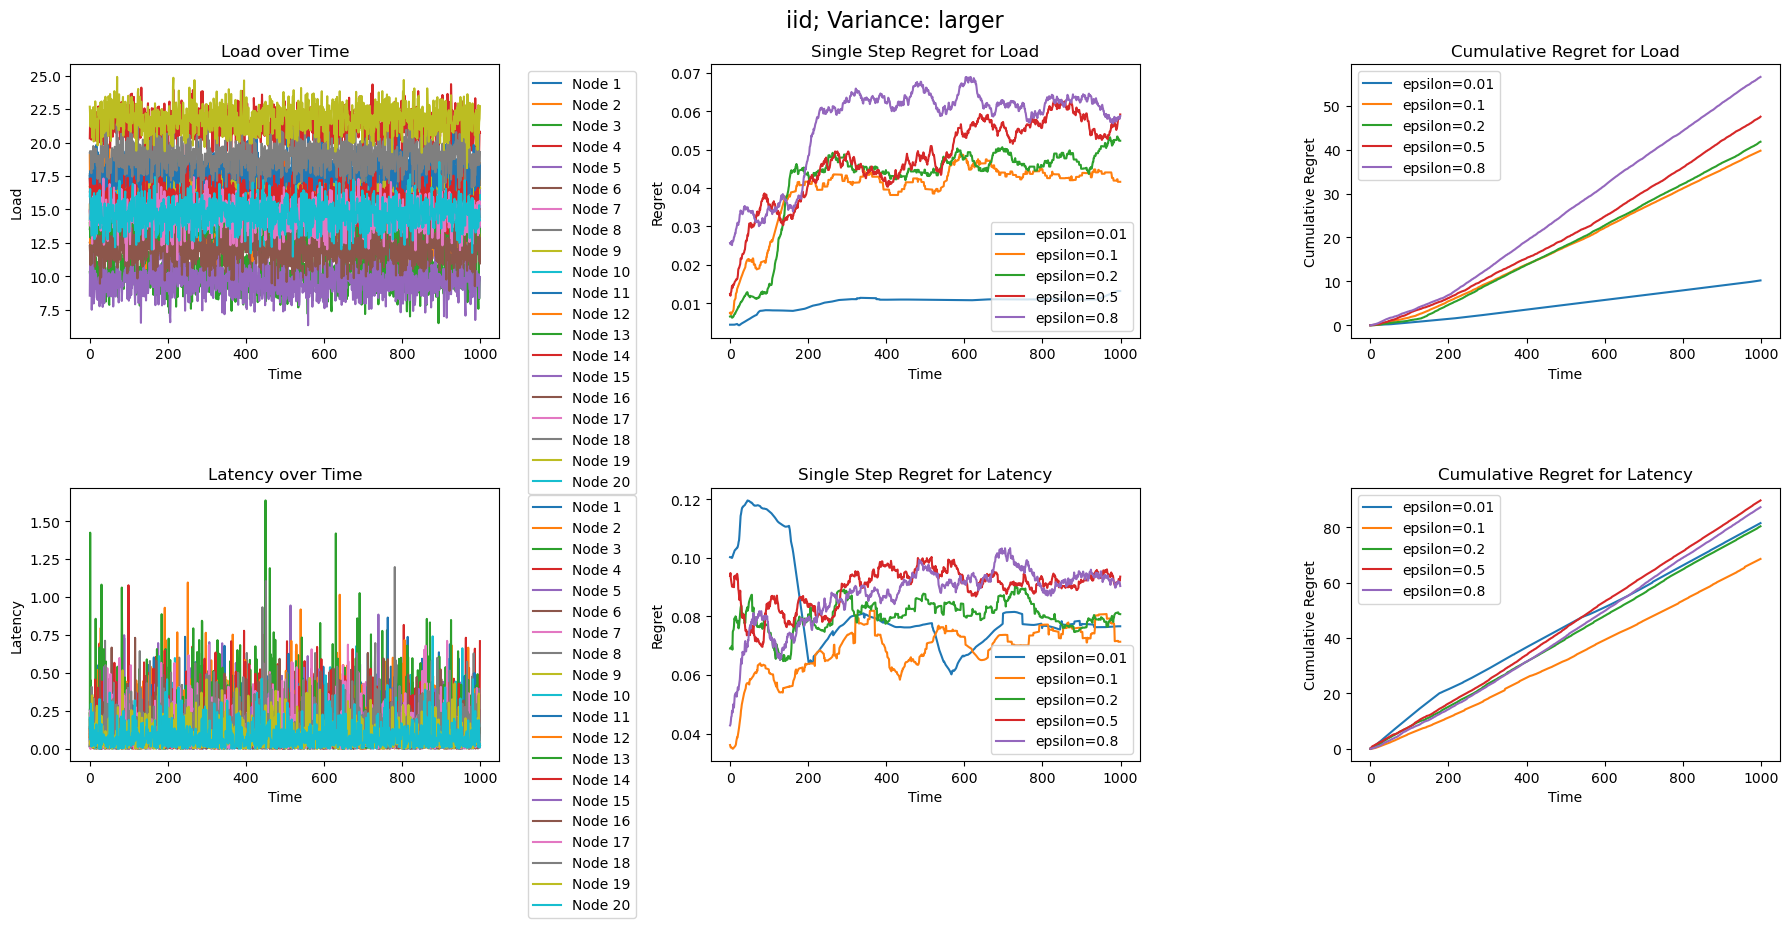

In [11]:
means_load, means_latency = generate_means(N, mean_load, var_load, mean_latency, var_latency)

load_ar1, latency_ar1 = generate_ar1_data(N, T, means_load, means_latency, theta)
results_ar1 = epsilon_greedy_algorithm(load_ar1, latency_ar1, epsilons)
plot_combined_results(load_ar1, latency_ar1, results_ar1, epsilons, 'AR(1); Variance: larger; Theta: 0.5')

load_iid, latency_iid = generate_iid_data(N, T, means_load, means_latency)
results_iid = epsilon_greedy_algorithm(load_iid, latency_iid, epsilons)
plot_combined_results(load_iid, latency_iid, results_iid, epsilons, 'iid; Variance: larger')

Mean Load: 15
Variance Load: 5
Mean Latency: 10
Variance Latency: 2


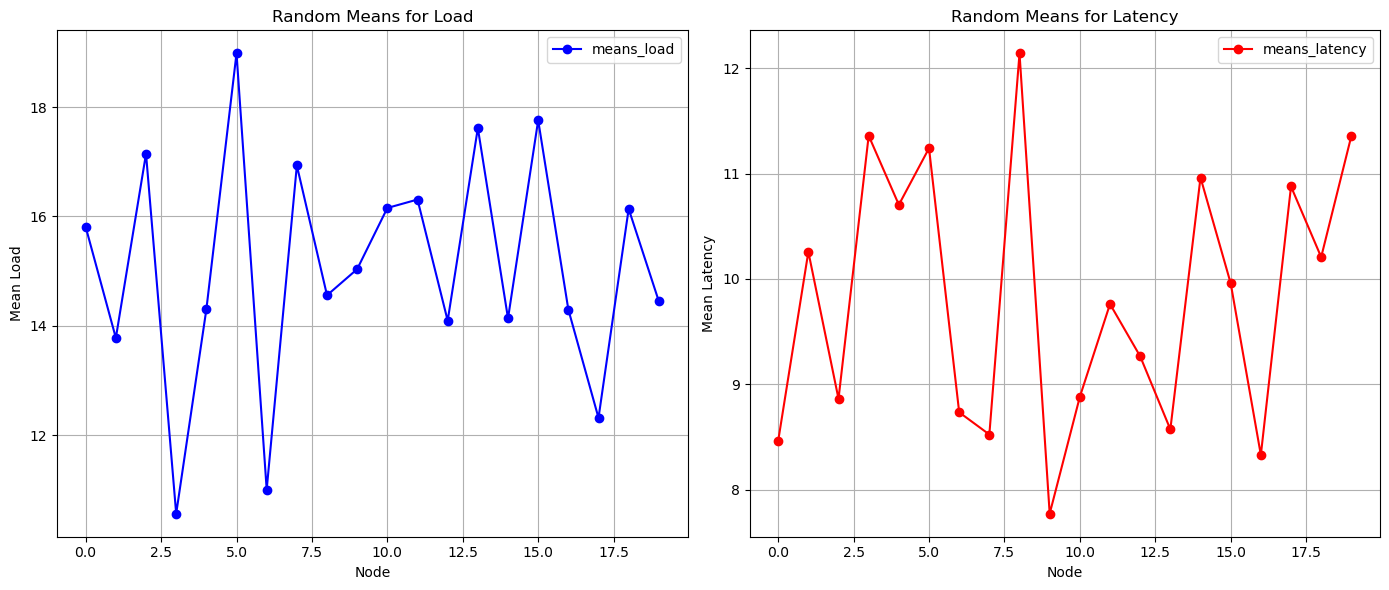

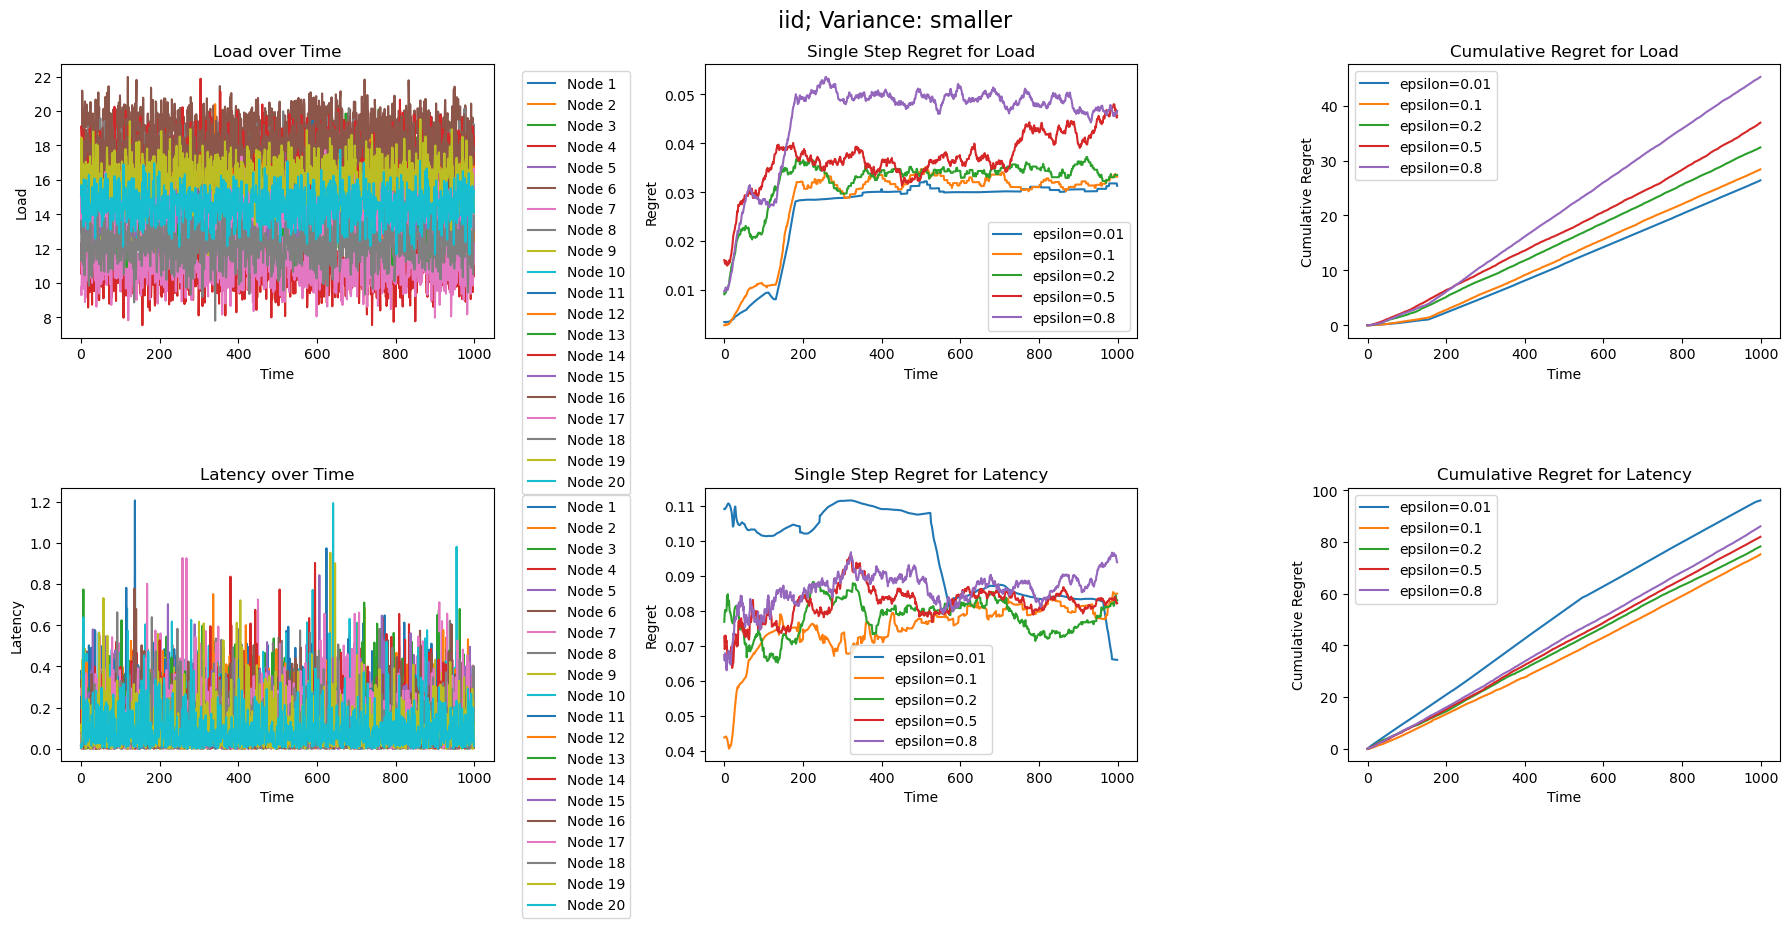

Theta: 0


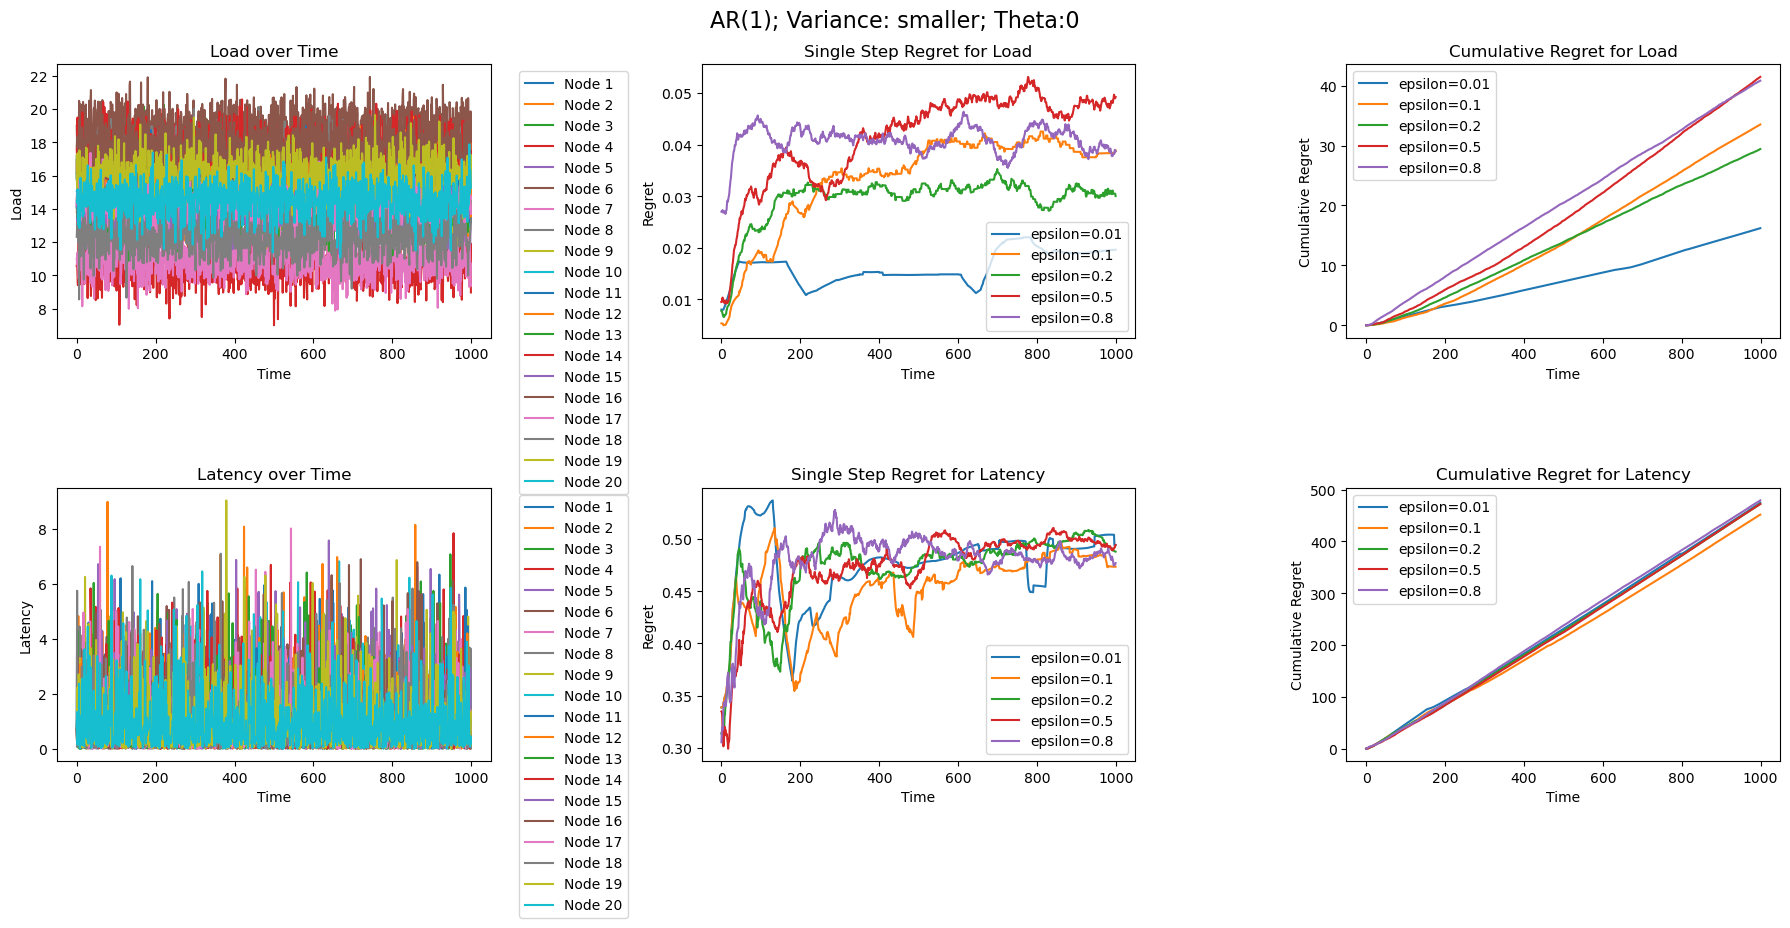

Theta: 0.2


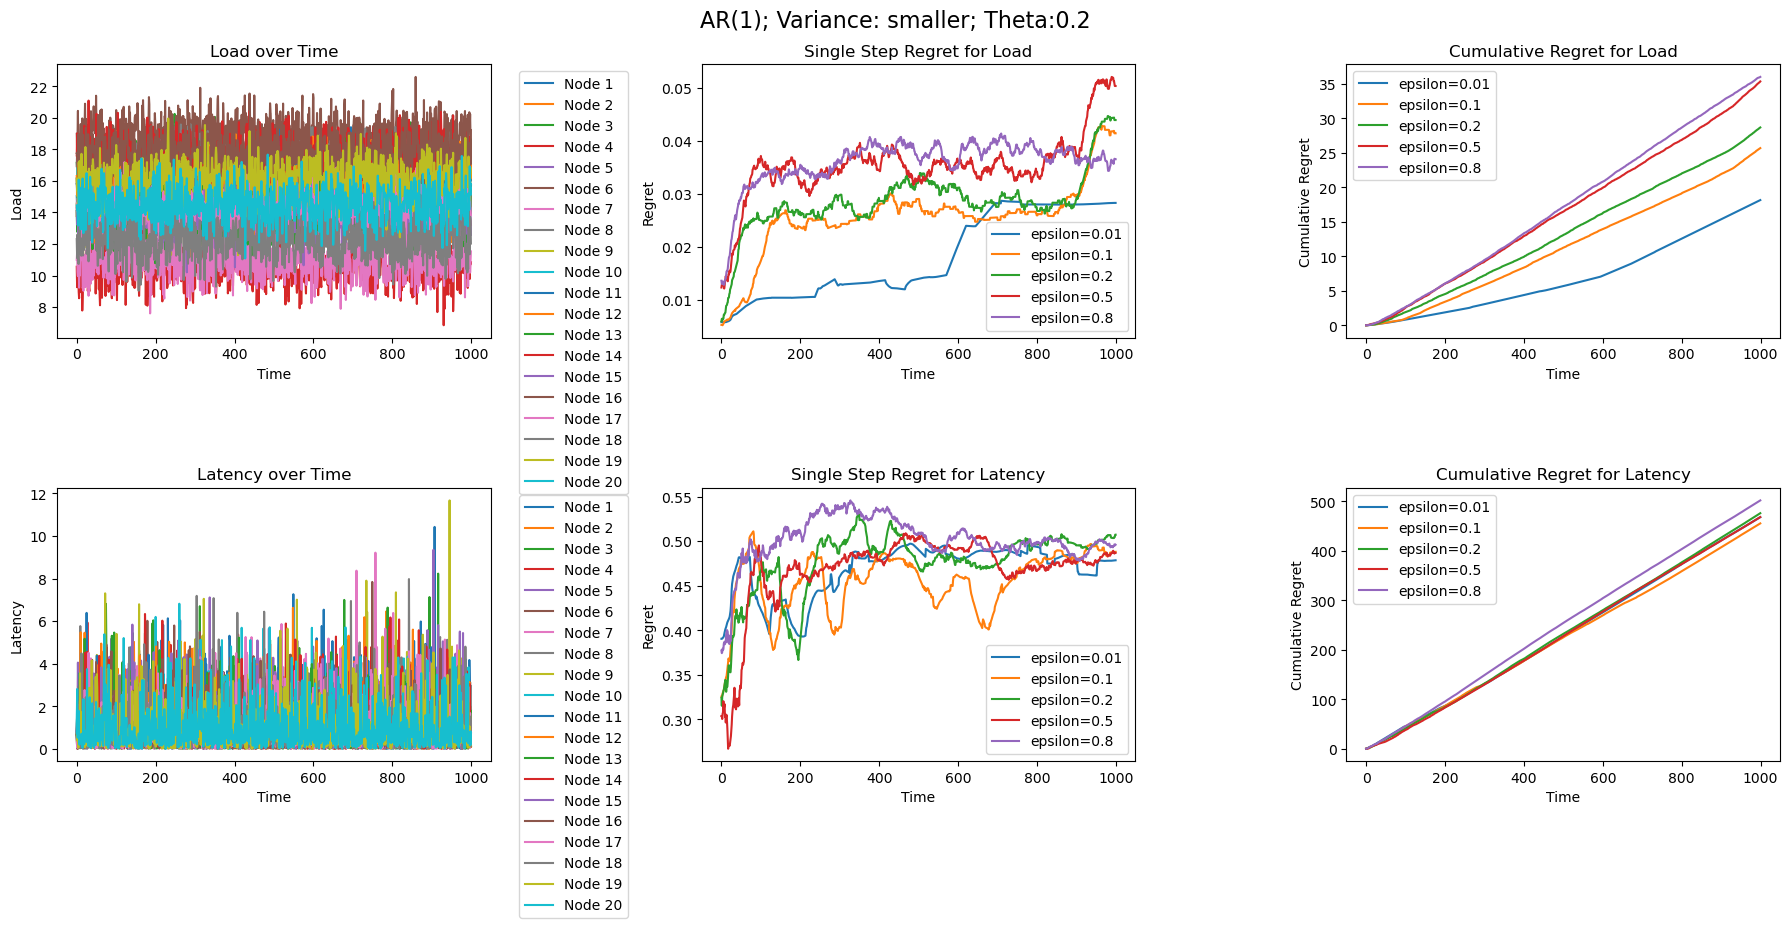

Theta: 0.5


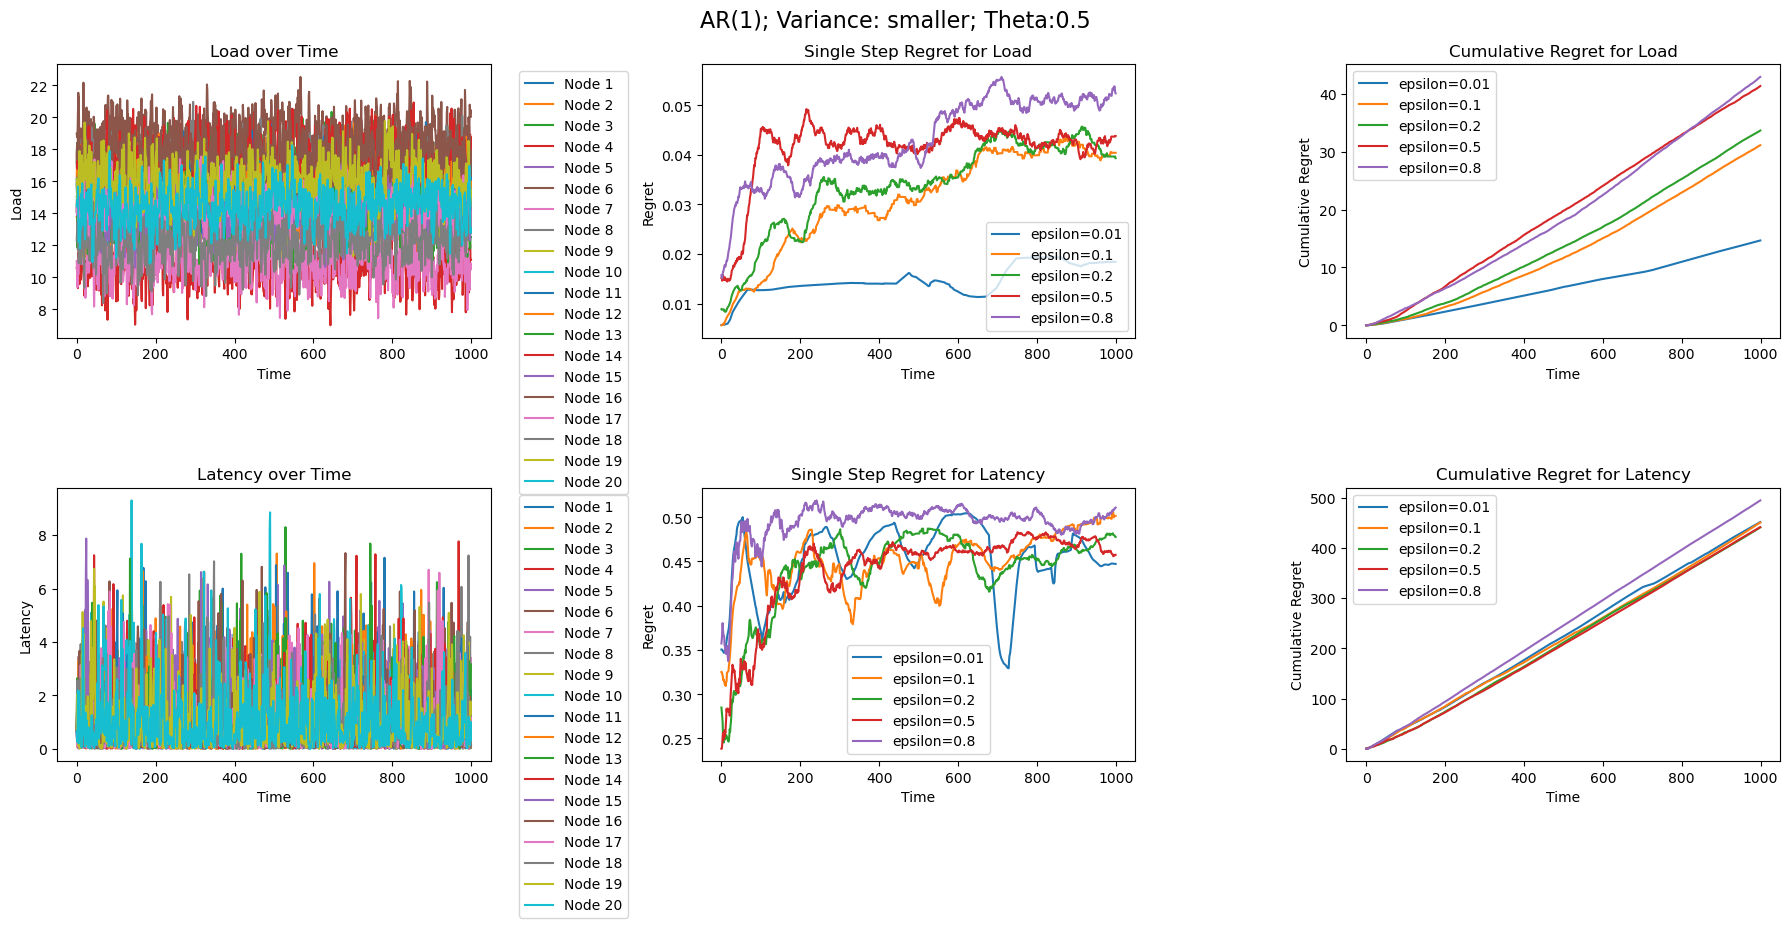

Theta: 0.8


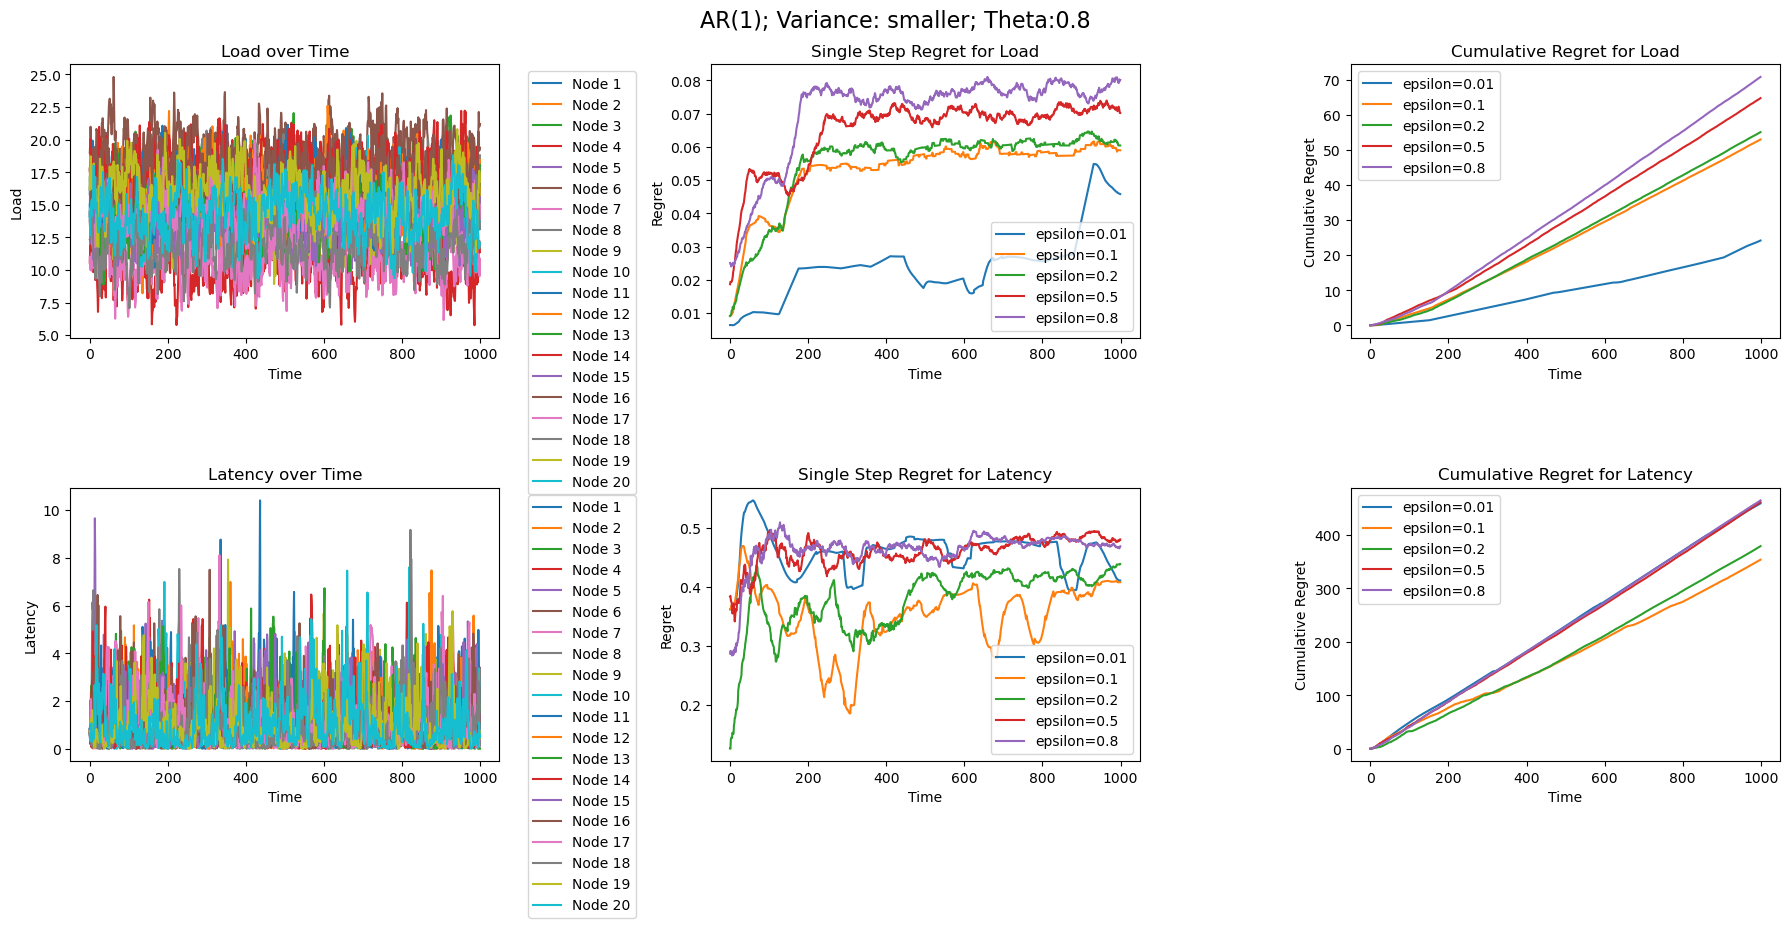

Theta: 1


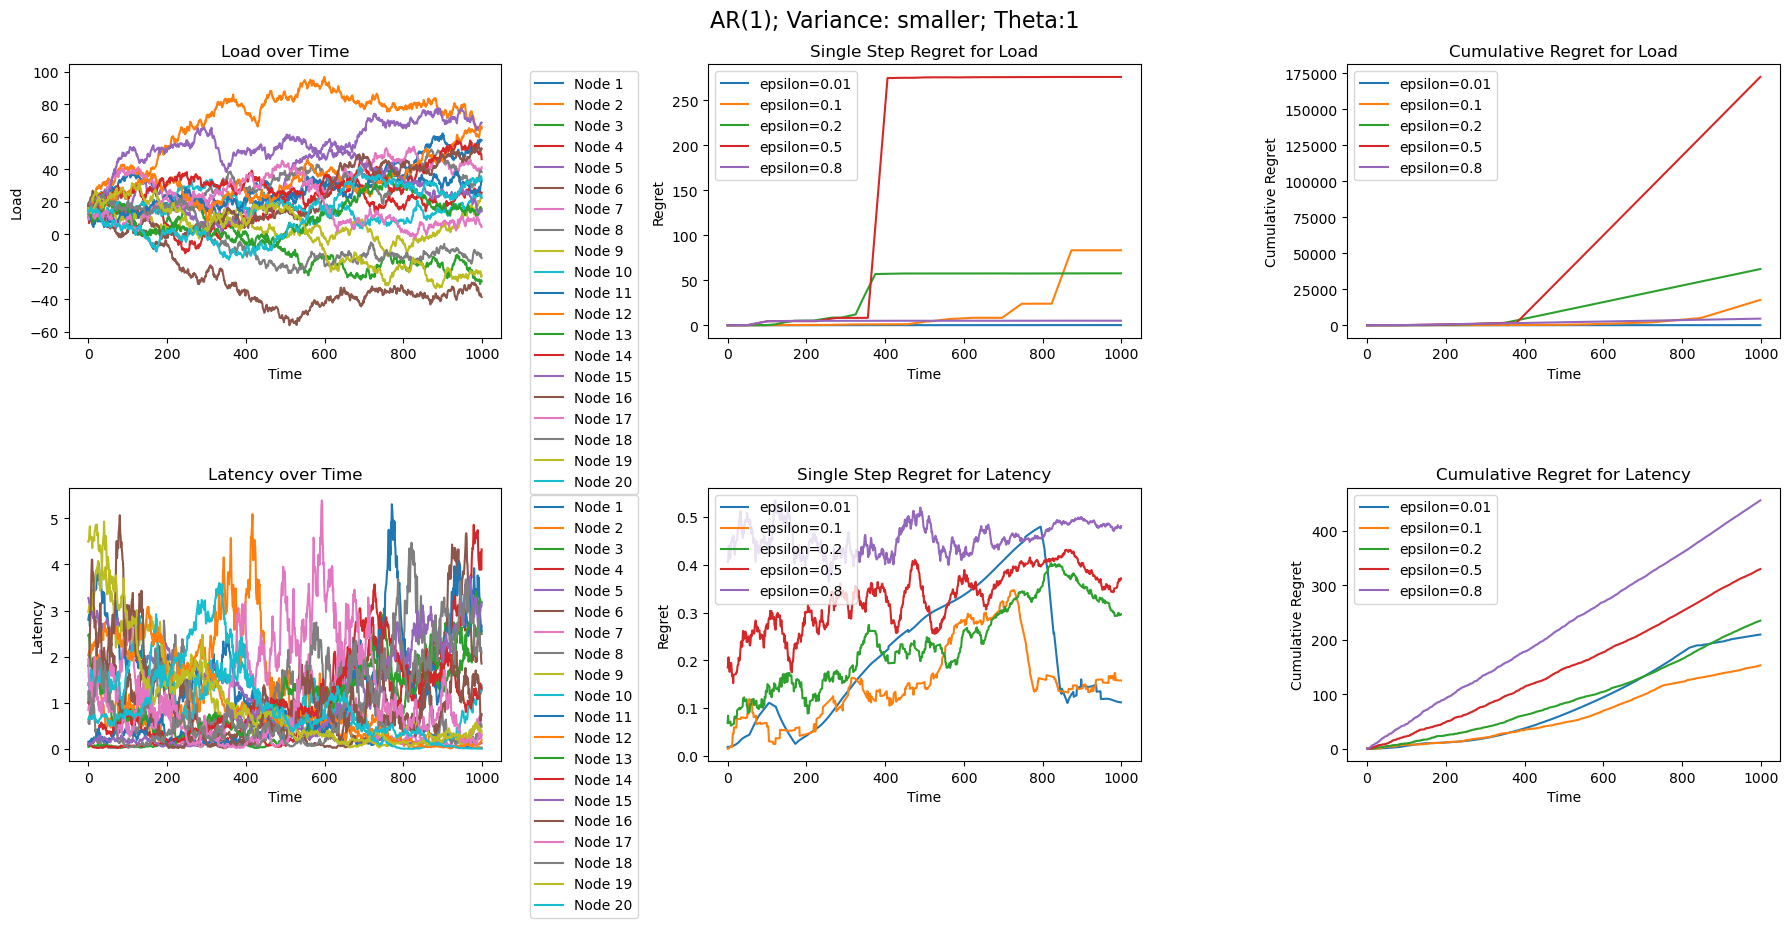

In [12]:
N = 20
T = 1000
mean_load = 15
var_load = 5
mean_latency = 10
var_latency = 2
epsilons = [0.01, 0.1, 0.2, 0.5, 0.8]

means_load, means_latency = generate_means(N, mean_load, var_load, mean_latency, var_latency)

load_iid, latency_iid = generate_iid_data(N, T, means_load, means_latency)
results_iid = epsilon_greedy_algorithm(load_iid, latency_iid, epsilons)
plot_combined_results(load_iid, latency_iid, results_iid, epsilons, 'iid; Variance: smaller')

for theta in [0, 0.2, 0.5, 0.8, 1]:
    load_ar1, latency_ar1 = generate_ar1_data(N, T, means_load, means_latency, theta)
    results_ar1 = epsilon_greedy_algorithm(load_ar1, latency_ar1, epsilons)
    plot_combined_results(load_ar1, latency_ar1, results_ar1, epsilons, f'AR(1); Variance: smaller; Theta:{theta}')

# Task 2

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

In [28]:
# 加载数据
vm_data = pd.read_csv('../real datasets/VM.csv')
macbook_pro1_data = pd.read_csv('../real datasets/MacBookPro1.csv')
macbook_pro2_data = pd.read_csv('../real datasets/MacBookPro2.csv')
raspberry_pi_data = pd.read_csv('../real datasets/RasberryPi.csv')

In [29]:
raspberry_pi_data

Time  Execution Time
0    Thu Nov 26 16:29:03 2020        3.167851
1    Thu Nov 26 16:29:05 2020        0.912467
2    Thu Nov 26 16:29:07 2020        1.013921
3    Thu Nov 26 16:29:09 2020        0.944200
4    Thu Nov 26 16:29:11 2020        0.916644
..                        ...             ...
995  Thu Nov 26 17:03:04 2020        0.925363
996  Thu Nov 26 17:03:06 2020        0.916802
997  Thu Nov 26 17:03:08 2020        0.929213
998  Thu Nov 26 17:03:10 2020        1.024313
999  Thu Nov 26 17:03:12 2020        0.931123

[1000 rows x 2 columns]

In [30]:
# 转换时间列为datetime格式
vm_data['Time'] = pd.to_datetime(vm_data['Time'])
macbook_pro1_data['Time'] = pd.to_datetime(macbook_pro1_data['Time'])
macbook_pro2_data['Time'] = pd.to_datetime(macbook_pro2_data['Time'])
raspberry_pi_data['Time'] = pd.to_datetime(raspberry_pi_data['Time'])

In [31]:
# 计算预期延迟（平均值和方差）
def calculate_delay_stats(data):
    mean_delay = data['Execution Time'].mean()
    var_delay = data['Execution Time'].var()
    return mean_delay, var_delay

vm_delay_mean, vm_delay_var = calculate_delay_stats(vm_data)
macbook_pro1_delay_mean, macbook_pro1_delay_var = calculate_delay_stats(macbook_pro1_data)
macbook_pro2_delay_mean, macbook_pro2_delay_var = calculate_delay_stats(macbook_pro2_data)
raspberry_pi_delay_mean, raspberry_pi_delay_var = calculate_delay_stats(raspberry_pi_data)

In [32]:
# 打印预期延迟结果
print(f"VM Server - Mean Delay: {vm_delay_mean}, Variance: {vm_delay_var}")
print(f"MacBook Pro 1 Server - Mean Delay: {macbook_pro1_delay_mean}, Variance: {macbook_pro1_delay_var}")
print(f"MacBook Pro 2 Server - Mean Delay: {macbook_pro2_delay_mean}, Variance: {macbook_pro2_delay_var}")
print(f"Raspberry Pi Server - Mean Delay: {raspberry_pi_delay_mean}, Variance: {raspberry_pi_delay_var}")

VM Server - Mean Delay: 0.42681368184089663, Variance: 0.4181247429071413
MacBook Pro 1 Server - Mean Delay: 0.10815345335006711, Variance: 5.832186598908575e-05
MacBook Pro 2 Server - Mean Delay: 0.34829165410995483, Variance: 0.008515416574744594
Raspberry Pi Server - Mean Delay: 1.0169308009147644, Variance: 0.01670383288729607


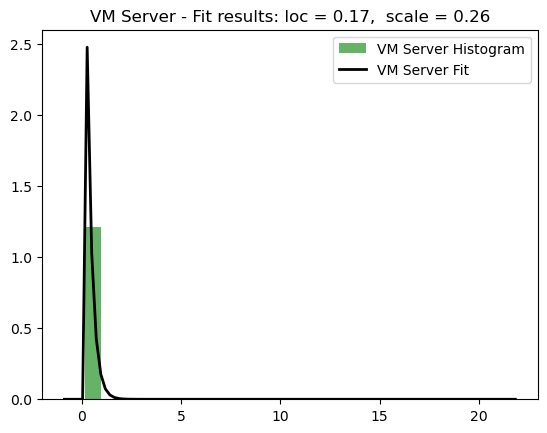

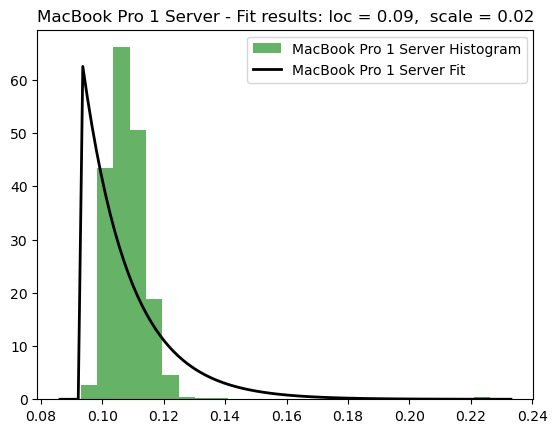

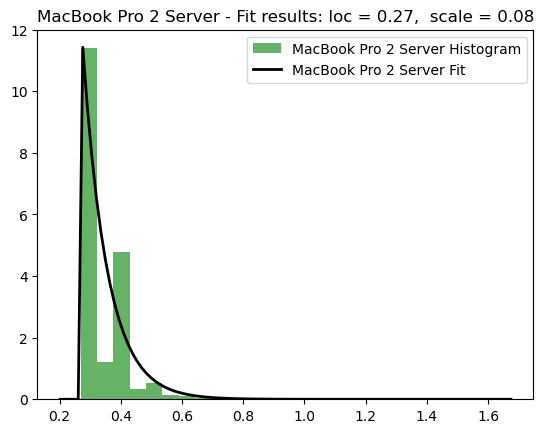

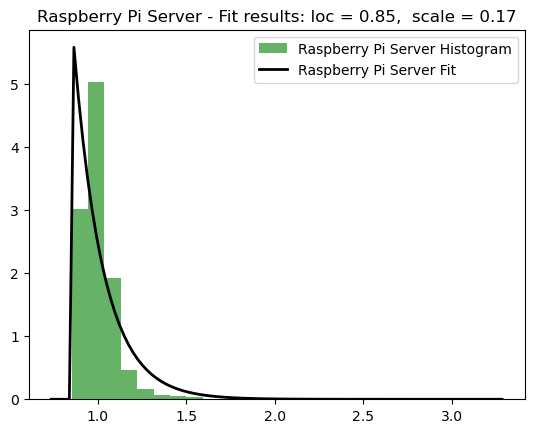

In [33]:
# 拟合指数分布模型
def fit_exponential_distribution(data, label):
    loc, scale = expon.fit(data['Execution Time'])
    plt.hist(data['Execution Time'], bins=25, density=True, alpha=0.6, color='g', label=f'{label} Histogram')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = expon.pdf(x, loc, scale)
    plt.plot(x, p, 'k', linewidth=2, label=f'{label} Fit')
    plt.title(f'{label} - Fit results: loc = {loc:.2f},  scale = {scale:.2f}')
    plt.legend(loc='best')
    plt.show()

fit_exponential_distribution(vm_data, 'VM Server')
fit_exponential_distribution(macbook_pro1_data, 'MacBook Pro 1 Server')
fit_exponential_distribution(macbook_pro2_data, 'MacBook Pro 2 Server')
fit_exponential_distribution(raspberry_pi_data, 'Raspberry Pi Server')

In [34]:
# 计算负载（在5秒间隔内的任务数）
def calculate_load(data, interval=5):
    data.set_index('Time', inplace=True)
    load = data['Execution Time'].resample(f'{interval}s').count()
    return load

vm_load = calculate_load(vm_data)

macbook_pro1_load = calculate_load(macbook_pro1_data)
macbook_pro2_load = calculate_load(macbook_pro2_data)
raspberry_pi_load = calculate_load(raspberry_pi_data)

In [35]:
# 打印负载结果的前5行
print("VM Server Load:\n", vm_load.head())
print("MacBook Pro 1 Server Load:\n", macbook_pro1_load.head())
print("MacBook Pro 2 Server Load:\n", macbook_pro2_load.head())
print("Raspberry Pi Server Load:\n", raspberry_pi_load.head())

VM Server Load:
 Time
2020-11-26 15:16:30    4
2020-11-26 15:16:35    4
2020-11-26 15:16:40    4
2020-11-26 15:16:45    4
2020-11-26 15:16:50    5
Freq: 5s, Name: Execution Time, dtype: int64
MacBook Pro 1 Server Load:
 Time
2020-11-26 14:47:35    2
2020-11-26 14:47:40    4
2020-11-26 14:47:45    5
2020-11-26 14:47:50    4
2020-11-26 14:47:55    5
Freq: 5s, Name: Execution Time, dtype: int64
MacBook Pro 2 Server Load:
 Time
2020-11-26 13:05:55    2
2020-11-26 13:06:00    4
2020-11-26 13:06:05    3
2020-11-26 13:06:10    4
2020-11-26 13:06:15    4
Freq: 5s, Name: Execution Time, dtype: int64
Raspberry Pi Server Load:
 Time
2020-11-26 16:29:00    1
2020-11-26 16:29:05    3
2020-11-26 16:29:10    2
2020-11-26 16:29:15    2
2020-11-26 16:29:20    2
Freq: 5s, Name: Execution Time, dtype: int64


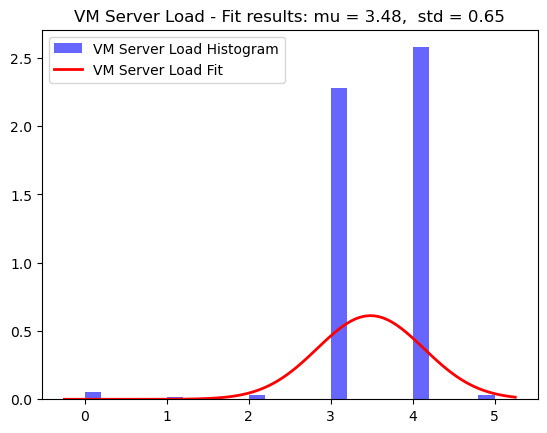

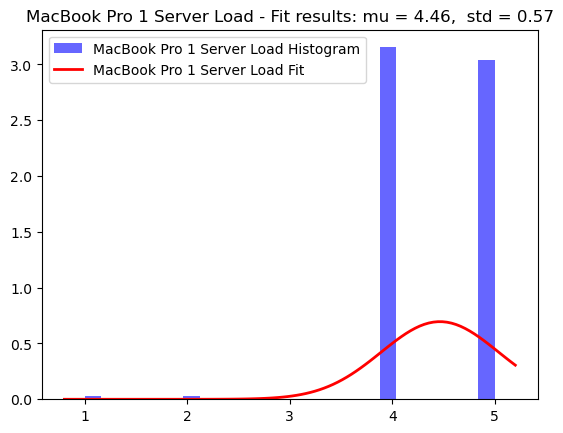

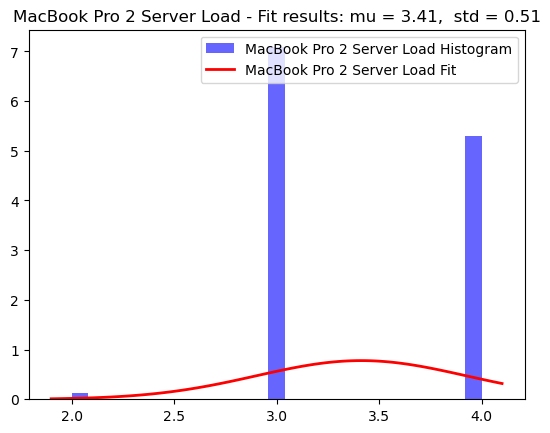

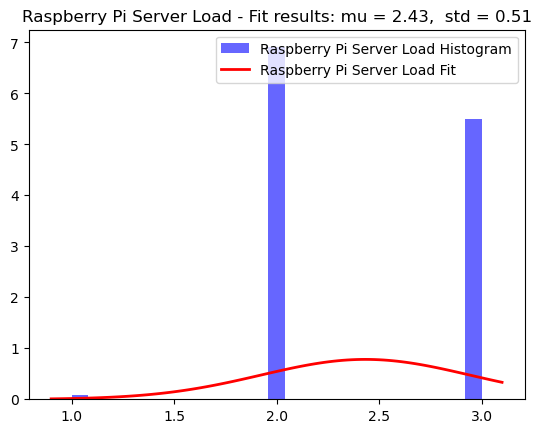

In [36]:
# 拟合负载分布模型
def fit_load_distribution(load, label):
    mu, std = norm.fit(load)
    plt.hist(load, bins=25, density=True, alpha=0.6, color='b', label=f'{label} Load Histogram')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label=f'{label} Load Fit')
    plt.title(f'{label} Load - Fit results: mu = {mu:.2f},  std = {std:.2f}')
    plt.legend(loc='best')
    plt.show()

fit_load_distribution(vm_load, 'VM Server')
fit_load_distribution(macbook_pro1_load, 'MacBook Pro 1 Server')
fit_load_distribution(macbook_pro2_load, 'MacBook Pro 2 Server')
fit_load_distribution(raspberry_pi_load, 'Raspberry Pi Server')


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# 加载数据
vm_df = pd.read_csv('../real datasets/VM.csv')
macbook1_df = pd.read_csv('../real datasets/MacBookPro1.csv')
macbook2_df = pd.read_csv('../real datasets/MacBookPro2.csv')
raspberrypi_df = pd.read_csv('../real datasets/RasberryPi.csv')

dfs = [vm_data, macbook_pro1_data, macbook_pro2_data, raspberry_pi_data]

results = []
for df in dfs:
    # 将第一列转换为datetime格式
    df['Time'] = pd.to_datetime(df['Time'])
    
    # 计算任务的结束时间
    df['End Time'] = df['Time'] + pd.to_timedelta(df['Execution Time'], unit='s')
    
    # 设定时间段范围，从最早的开始时间到最晚的结束时间
    start_time = df['Time'].min()
    end_time = df['End Time'].max()
    time_range = pd.date_range(start=start_time, end=end_time, freq='5s')
    
    # 初始化负载统计列表
    load_data = []
    
    # 计算每个时间段的负载
    for i in range(len(time_range) - 1):
        start_interval = time_range[i]
        end_interval = time_range[i + 1]
        load = ((df['Time'] < end_interval) & (df['End Time'] >= start_interval)).sum()
        load_data.append({'time': start_interval, 'load': load})
    
    results.append(pd.DataFrame(load_data))
    
# 转换为DataFrame
results_df = pd.DataFrame(results)
results_df

KeyError: 'Time'

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# 加载数据
vm_df = pd.read_csv('../real datasets/VM.csv')
macbook1_df = pd.read_csv('../real datasets/MacBookPro1.csv')
macbook2_df = pd.read_csv('../real datasets/MacBookPro2.csv')
raspberrypi_df = pd.read_csv('../real datasets/RasberryPi.csv')

# 将DataFrame列表放入一个字典中以便管理
dfs = {
    'VM': vm_df,
    'MacBookPro1': macbook1_df,
    'MacBookPro2': macbook2_df,
    'RaspberryPi': raspberrypi_df
}

# 初始化结果列表
results = []

for name, df in dfs.items():
    # 将第一列转换为datetime格式
    df['Time'] = pd.to_datetime(df['Time'])

    # 计算任务的结束时间
    df['End Time'] = df['Time'] + pd.to_timedelta(df['Execution Time'], unit='s')

    # 设定时间段范围，从最早的开始时间到最晚的结束时间
    start_time = df['Time'].min()
    end_time = df['End Time'].max()
    time_range = pd.date_range(start=start_time, end=end_time, freq='5s')

    # 初始化负载统计列表
    load_data = []

    # 计算每个时间段的负载
    for i in range(len(time_range) - 1):
        start_interval = time_range[i]
        end_interval = time_range[i + 1]
        load = ((df['Time'] < end_interval) & (df['End Time'] >= start_interval)).sum()
        load_data.append({'time': start_interval, 'load': load})

    # 添加结果到结果列表
    results.append(load_data)

results_df = pd.DataFrame(results)
results_df

0    \
0  {'time': 2020-11-26 15:16:31, 'load': 4}   
1  {'time': 2020-11-26 14:47:38, 'load': 5}   
2  {'time': 2020-11-26 13:05:57, 'load': 4}   
3  {'time': 2020-11-26 16:29:03, 'load': 3}   

                                        1    \
0  {'time': 2020-11-26 15:16:36, 'load': 5}   
1  {'time': 2020-11-26 14:47:43, 'load': 4}   
2  {'time': 2020-11-26 13:06:02, 'load': 3}   
3  {'time': 2020-11-26 16:29:08, 'load': 3}   

                                        2    \
0  {'time': 2020-11-26 15:16:41, 'load': 4}   
1  {'time': 2020-11-26 14:47:48, 'load': 5}   
2  {'time': 2020-11-26 13:06:07, 'load': 4}   
3  {'time': 2020-11-26 16:29:13, 'load': 2}   

                                        3    \
0  {'time': 2020-11-26 15:16:46, 'load': 4}   
1  {'time': 2020-11-26 14:47:53, 'load': 4}   
2  {'time': 2020-11-26 13:06:12, 'load': 3}   
3  {'time': 2020-11-26 16:29:18, 'load': 2}   

                                        4    \
0  {'time': 2020-11-26 15:16:51, 'load': 4}   
1  {'time': 2020-11-26 14:47:58, 'load': 5}   
2  {'time': 2020-11-26 13:06:17, 'load': 4}   
3  {'time': 2020-11-26 16:29:23, 'load': 3}   

                                        5    \
0  {'time': 2020-11-26 15:16:56, 'load': 4}   
1  {'time': 2020-11-26 14:48:03, 'load': 4}   
2  {'time': 2020-11-26 13:06:22, 'load': 3}   
3  {'time': 2020-11-26 16:29:28, 'load': 3}   

                                        6    \
0  {'time': 2020-11-26 15:17:01, 'load': 3}   
1  {'time': 2020-11-26 14:48:08, 'load': 5}   
2  {'time': 2020-11-26 13:06:27, 'load': 4}   
3  {'time': 2020-11-26 16:29:33, 'load': 3}   

                                        7    \
0  {'time': 2020-11-26 15:17:06, 'load': 4}   
1  {'time': 2020-11-26 14:48:13, 'load': 4}   
2  {'time': 2020-11-26 13:06:32, 'load': 3}   
3  {'time': 2020-11-26 16:29:38, 'load': 3}   

                                        8    \
0  {'time': 2020-11-26 15:17:11, 'load': 3}   
1  {'time': 2020-11-26 14:48:18, 'load': 5}   
2  {'time': 2020-11-26 13:06:37, 'load': 4}   
3  {'time': 2020-11-26 16:29:43, 'load': 3}   

                                        9    ...  \
0  {'time': 2020-11-26 15:17:16, 'load': 4}  ...   
1  {'time': 2020-11-26 14:48:23, 'load': 4}  ...   
2  {'time': 2020-11-26 13:06:42, 'load': 3}  ...   
3  {'time': 2020-11-26 16:29:48, 'load': 2}  ...   

                                        399  \
0                                      None   
1                                      None   
2                                      None   
3  {'time': 2020-11-26 17:02:18, 'load': 3}   

                                        400  \
0                                      None   
1                                      None   
2                                      None   
3  {'time': 2020-11-26 17:02:23, 'load': 3}   

                                        401  \
0                                      None   
1                                      None   
2                                      None   
3  {'time': 2020-11-26 17:02:28, 'load': 2}   

                                        402  \
0                                      None   
1                                      None   
2                                      None   
3  {'time': 2020-11-26 17:02:33, 'load': 3}   

                                        403  \
0                                      None   
1                                      None   
2                                      None   
3  {'time': 2020-11-26 17:02:38, 'load': 3}   

                                        404  \
0                                      None   
1                                      None   
2                                      None   
3  {'time': 2020-11-26 17:02:43, 'load': 2}   

                                        405  \
0                                      None   
1                                      None   
2                                      None   
3  {'time': 2020-11-26 17:02:48, 'load': 3}   

   

In [42]:
load_df

time  load
0   2020-11-26 14:47:38     5
1   2020-11-26 14:47:43     4
2   2020-11-26 14:47:48     5
3   2020-11-26 14:47:53     4
4   2020-11-26 14:47:58     5
..                  ...   ...
217 2020-11-26 15:05:43     5
218 2020-11-26 15:05:48     4
219 2020-11-26 15:05:53     5
220 2020-11-26 15:05:58     4
221 2020-11-26 15:06:03     5

[222 rows x 2 columns]